In [2]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

                     Energy_Consumption
Start_DateTime                         
2018-01-01 17:49:00               6.504
2018-01-01 17:49:00               6.504
2018-01-02 08:52:00               2.481
2018-01-02 08:52:00               2.481
2018-01-02 21:11:00              15.046
...                                 ...
2019-08-06 08:48:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 10:17:00              11.060
2019-08-07 10:17:00              11.060

[968 rows x 1 columns]


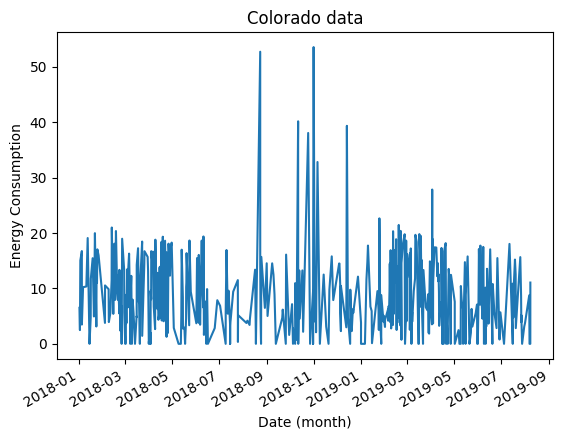

In [3]:
df = pd.read_csv('ColoradoData_Boulder.csv')
df.index = df['Start_DateTime']
df = df[['Start_DateTime', 'Energy_Consumption']].sort_index()
df.dropna(inplace=True)
df['Start_DateTime'] = pd.to_datetime(df['Start_DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Start_DateTime', inplace=True)
print(df)

plt.title("Colorado data")
plt.ylabel("Energy Consumption")
plt.xlabel("Date (month)")
plt.plot(df['Energy_Consumption'])
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [13]:
class LSTM(L.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
        super().__init__()
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        train_loss = self.criterion(y_hat, y) 
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.criterion(y_hat, y)
        self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
params = dict(
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  max_epochs = 5,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 1, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  # num_workers = 5,
  scaler = MinMaxScaler()
)

In [11]:
X = df.copy()
y = X['Energy_Consumption'].shift(-1).ffill()
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.25, shuffle=False)

preprocessing = params['scaler']
preprocessing.fit(X_train)

X_train = preprocessing.transform(X_train)
y_train = y_train.values.reshape((-1, 1))
X_val = preprocessing.transform(X_val)
y_val = y_val.values.reshape((-1, 1))
X_test = preprocessing.transform(X_test)
y_test = y_test.values.reshape((-1, 1))

In [20]:
train_dataset = TimeSeriesDataset(X_train, y_train, seq_len=params['seq_len'])
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)

val_dataset = TimeSeriesDataset(X_val, y_val, seq_len=params['seq_len'])
val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

test_dataset = TimeSeriesDataset(X_test, y_test, seq_len=params['seq_len'])
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

model = LSTM(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers'], criterion=params['criterion'], dropout=params['dropout'], learning_rate=params['learning_rate'])
trainer = L.Trainer(max_epochs=params['max_epochs'], fast_dev_run=100)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 72/72 [00:00<00:00, 125.26it/s, train_loss_step=0.414, val_loss_step=6.000, val_loss_epoch=50.20, train_loss_epoch=87.30]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 345.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         35.25019836425781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 35.25019836425781}]